<a href="https://colab.research.google.com/github/Daegil2/practice/blob/main/word_pytorch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import warnings
from tqdm import tqdm
from glob import glob
from PIL import Image
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedKFold

In [3]:
#경고 무시
warnings.filterwarnings(action='ignore')

In [4]:
#추가 
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [5]:
# torch version check
print('torch version: ', torch.__version__)

torch version:  1.10.0+cu111


In [6]:
# GPU 설정
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device: ', device)

device:  cuda:0


In [7]:
# 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)
else: torch.manual_seed(42)

In [8]:
train=pd.read_csv('/content/gdrive/MyDrive/corab/word/train/train_data.csv')
test=pd.read_csv('/content/gdrive/MyDrive/corab/word/test/test_data.csv')

In [9]:
train

,file_name,label
0,train0001.png,8
1,train0002.png,8
2,train0003.png,8
3,train0004.png,8
4,train0005.png,8
...,...,...
4995,train4996.png,6
4996,train4997.png,6
4997,train4998.png,6
4998,train4999.png,6


In [10]:
test

,file_name
0,idx0001.png
1,idx0002.png
2,idx0003.png
3,idx0004.png
4,idx0005.png
...,...
4995,idx4996.png
4996,idx4997.png
4997,idx4998.png
4998,idx4999.png


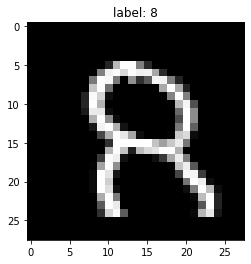

In [40]:
sample_image = Image.open('/content/gdrive/MyDrive/corab/word/train/' + train['file_name'][0])
sample_label = train['label'][0]
plt.title('label: ' + str(sample_label))
plt.imshow(sample_image, cmap='gray')

In [13]:
def get_img_list(series, root_path):
    reshaped_image_list=[]

    for file_name in series:
        image_path = root_path +file_name
        image= Image.open(image_path)
        image_array = np.array(image)
        reshaped_image = image_array.reshape(28,28,1)
        reshaped_image_list.append(reshaped_image)
    return reshaped_image_list

In [14]:
def get_transform(mode='train'):

    t=list()
    t.append(transforms.ToTensor())

    if mode =='train':
        t.append(transforms.RandomAffine(degrees=10, translate =(0.1,0.1)))

    t.append(transforms.Normalize(mean=(.5), std=(.5)))

    return transforms.Compose(t)


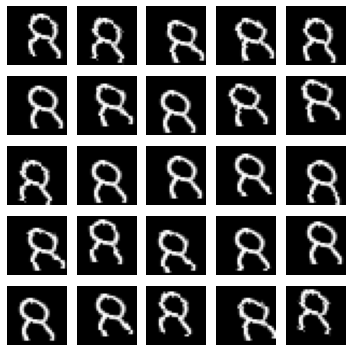

In [15]:
# Augmented Image 확인
sample_transform =get_transform()
sample_array= np.array(sample_image)

nrows, ncols =5,5
fig, ax = plt.subplots(nrows =nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        sample_augmented_image = sample_transform(sample_array).reshape(28,28)
        ax[i][j].imshow(sample_augmented_image, cmap='gray')
        ax[i][j].axis('off')

plt.tight_layout()
plt.show()

In [16]:
class CustomDataset(Dataset):
    def __init__(self, mode, img_list, label=None):
        self.mode =mode # train or test
        self.transform =get_transform(mode)
        self.img_list =img_list
        self.label =label #정답값
        self.transformed_img_list =list(map(self.transform, self.img_list))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, i):

        x_data=self.transformed_img_list[i]

        if self.mode =='train':
            return {
                'X':x_data,
                'Y': torch.tensor(self.label[i], dtype=torch.long)

            }
        else:
            return {'X':x_data}


In [17]:
def get_dataloader(x,y,root_path, mode='train'):
    shuffle =True if mode =='train' else False
    img_list =get_img_list(x, root_path)
    dataset= CustomDataset(mode=mode, img_list =img_list, label=y)
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle =shuffle)
    total_batch = math.ceil(len(dataset)/batch_size)

    return dataloader, total_batch

In [18]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(batch_size, 28, 28, 2)
        #    Conv     -> (batch_size, 28, 28, 16)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.Dropout(p=0.3))
        
        # 두번째층
        # ImgIn shape=(batch_size, 28, 28, 16)
        #    Conv      ->(batch_size, 28, 28, 32)
        #    Pool      ->(batch_size, 9, 9, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=5, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=3, stride=3),
            torch.nn.Dropout(p=0.3))
        
        # 세번째층
        # ImgIn shape=(batch_size, 9, 9, 32)
        #    Conv      ->(batch_size, 9, 9, 64)
        #    Pool      ->(batch_size, 3, 3, 64)        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same'),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=3, stride=3),
            torch.nn.Dropout(p=0.3))
        
        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(3*3*64, 10, bias=True)

        torch.nn.init.xavier_uniform_(self.fc.weight) # fc 가중치 초기화

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten
        out = self.fc(out)
        return out

In [47]:
class EarlyStopping:
    # 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', k_num=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.k_num = k_num

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{k_num}.pt')
        self.val_loss_min = val_loss

"""
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""

In [20]:
model =CNN().to(device)

In [42]:
root_path= os.getcwd()+'/gdrive/MyDrive/corab/word/train/'
batch_size = 64
epochs = 2000
learning_rate = 0.002
save_path = '/content/gdrive/MyDrive/corab/word/'
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                    lr_lambda=lambda epoch: 0.95 ** epoch,
                                                    last_epoch=-1,
                                                    verbose=False)

In [43]:
os.getcwd()

'/content'

In [48]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
k_num = 0

for train_index, valid_index in skf.split(train['file_name'], train['label']) :
    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    k_num += 1
    early_stopping = EarlyStopping(patience = 300, verbose = True, path = save_path, k_num = k_num)
    
    x_train = train['file_name'][train_index].reset_index(drop=True)
    x_valid = train['file_name'][valid_index].reset_index(drop=True)
    y_train = train['label'][train_index].reset_index(drop=True)
    y_valid = train['label'][valid_index].reset_index(drop=True)

    train_dataloader, train_total_batch = get_dataloader(x_train, y_train, root_path, mode='train')
    valid_dataloader, valid_total_batch = get_dataloader(x_valid, y_valid, root_path, mode='train')
    
    for epoch in tqdm(range(epochs)) :
        train_avg_cost, valid_avg_cost = 0, 0

        for batch in train_dataloader :
            train_X = batch['X'].to(device)
            train_Y = batch['Y'].to(device)

            optimizer.zero_grad()
            hypothesis = model(train_X)
            cost = criterion(hypothesis, train_Y)
            cost.backward()
            optimizer.step()
            train_avg_cost += cost / train_total_batch

        scheduler.step()

        model.eval()
        for batch in valid_dataloader :
            valid_X = batch['X'].to(device)
            valid_Y = batch['Y'].to(device)

            with torch.no_grad() :
                hypothesis = model(valid_X)
                cost = criterion(hypothesis, valid_Y)
                valid_avg_cost += cost / valid_total_batch        

        early_stopping(float(valid_avg_cost), model)
        if early_stopping.early_stop:
            print("Early stopping!!")
            break            

  0%|          | 1/2000 [00:01<53:27,  1.60s/it]

Validation loss decreased (inf --> 0.315036).  Saving model ...


  0%|          | 2/2000 [00:03<50:06,  1.50s/it]

Validation loss decreased (0.315036 --> 0.272958).  Saving model ...


  0%|          | 3/2000 [00:04<48:57,  1.47s/it]

Validation loss decreased (0.272958 --> 0.117949).  Saving model ...


  0%|          | 6/2000 [00:08<47:45,  1.44s/it]

Validation loss decreased (0.117949 --> 0.089353).  Saving model ...


  0%|          | 8/2000 [00:11<47:42,  1.44s/it]

Validation loss decreased (0.089353 --> 0.066523).  Saving model ...


  1%|          | 22/2000 [00:31<46:51,  1.42s/it]

Validation loss decreased (0.066523 --> 0.064521).  Saving model ...


 16%|█▌        | 321/2000 [07:37<39:53,  1.43s/it]

Early stopping!!



  0%|          | 1/2000 [00:01<52:59,  1.59s/it]

Validation loss decreased (inf --> 0.605192).  Saving model ...


  0%|          | 2/2000 [00:03<50:06,  1.50s/it]

Validation loss decreased (0.605192 --> 0.143803).  Saving model ...


  0%|          | 4/2000 [00:05<48:17,  1.45s/it]

Validation loss decreased (0.143803 --> 0.127727).  Saving model ...


  0%|          | 7/2000 [00:10<47:49,  1.44s/it]

Validation loss decreased (0.127727 --> 0.114454).  Saving model ...


  0%|          | 8/2000 [00:11<48:03,  1.45s/it]

Validation loss decreased (0.114454 --> 0.106231).  Saving model ...


  0%|          | 9/2000 [00:13<47:57,  1.45s/it]

Validation loss decreased (0.106231 --> 0.084072).  Saving model ...


  2%|▏         | 36/2000 [00:51<46:38,  1.42s/it]

Validation loss decreased (0.084072 --> 0.083447).  Saving model ...


  2%|▏         | 45/2000 [01:04<46:33,  1.43s/it]

Validation loss decreased (0.083447 --> 0.075681).  Saving model ...


  2%|▏         | 46/2000 [01:05<46:32,  1.43s/it]

Validation loss decreased (0.075681 --> 0.075594).  Saving model ...


  2%|▏         | 47/2000 [01:07<46:36,  1.43s/it]

Validation loss decreased (0.075594 --> 0.074893).  Saving model ...


  2%|▏         | 49/2000 [01:10<46:27,  1.43s/it]

Validation loss decreased (0.074893 --> 0.074507).  Saving model ...


  3%|▎         | 52/2000 [01:14<46:27,  1.43s/it]

Validation loss decreased (0.074507 --> 0.074126).  Saving model ...


  3%|▎         | 54/2000 [01:17<46:24,  1.43s/it]

Validation loss decreased (0.074126 --> 0.073966).  Saving model ...


  3%|▎         | 56/2000 [01:20<46:18,  1.43s/it]

Validation loss decreased (0.073966 --> 0.073871).  Saving model ...


  3%|▎         | 58/2000 [01:22<46:13,  1.43s/it]

Validation loss decreased (0.073871 --> 0.073825).  Saving model ...


  3%|▎         | 60/2000 [01:25<46:26,  1.44s/it]

Validation loss decreased (0.073825 --> 0.073727).  Saving model ...


  3%|▎         | 63/2000 [01:30<46:20,  1.44s/it]

Validation loss decreased (0.073727 --> 0.073691).  Saving model ...


 18%|█▊        | 362/2000 [08:36<38:55,  1.43s/it]

Early stopping!!



  0%|          | 1/2000 [00:01<52:57,  1.59s/it]

Validation loss decreased (inf --> 0.265722).  Saving model ...


  0%|          | 2/2000 [00:03<50:18,  1.51s/it]

Validation loss decreased (0.265722 --> 0.193948).  Saving model ...


  0%|          | 3/2000 [00:04<49:20,  1.48s/it]

Validation loss decreased (0.193948 --> 0.104394).  Saving model ...


  0%|          | 5/2000 [00:07<48:17,  1.45s/it]

Validation loss decreased (0.104394 --> 0.088356).  Saving model ...


 15%|█▌        | 304/2000 [07:13<40:19,  1.43s/it]

Early stopping!!



  0%|          | 1/2000 [00:01<52:25,  1.57s/it]

Validation loss decreased (inf --> 0.280009).  Saving model ...


  0%|          | 2/2000 [00:03<49:37,  1.49s/it]

Validation loss decreased (0.280009 --> 0.225848).  Saving model ...


  0%|          | 3/2000 [00:04<48:56,  1.47s/it]

Validation loss decreased (0.225848 --> 0.163446).  Saving model ...


  0%|          | 4/2000 [00:05<48:27,  1.46s/it]

Validation loss decreased (0.163446 --> 0.117112).  Saving model ...


  0%|          | 7/2000 [00:10<47:44,  1.44s/it]

Validation loss decreased (0.117112 --> 0.099809).  Saving model ...


  0%|          | 9/2000 [00:13<47:39,  1.44s/it]

Validation loss decreased (0.099809 --> 0.086575).  Saving model ...


  0%|          | 10/2000 [00:14<47:42,  1.44s/it]

Validation loss decreased (0.086575 --> 0.080340).  Saving model ...


  1%|          | 20/2000 [00:28<47:11,  1.43s/it]

Validation loss decreased (0.080340 --> 0.078949).  Saving model ...


  1%|          | 21/2000 [00:30<47:16,  1.43s/it]

Validation loss decreased (0.078949 --> 0.071136).  Saving model ...


  1%|          | 22/2000 [00:31<47:16,  1.43s/it]

Validation loss decreased (0.071136 --> 0.065794).  Saving model ...


  1%|          | 23/2000 [00:33<47:14,  1.43s/it]

Validation loss decreased (0.065794 --> 0.058330).  Saving model ...


  1%|          | 24/2000 [00:34<47:17,  1.44s/it]

Validation loss decreased (0.058330 --> 0.057417).  Saving model ...


  1%|▏         | 25/2000 [00:35<47:19,  1.44s/it]

Validation loss decreased (0.057417 --> 0.056836).  Saving model ...


  1%|▏         | 26/2000 [00:37<47:22,  1.44s/it]

Validation loss decreased (0.056836 --> 0.056663).  Saving model ...


  1%|▏         | 27/2000 [00:38<47:24,  1.44s/it]

Validation loss decreased (0.056663 --> 0.056162).  Saving model ...


  1%|▏         | 29/2000 [00:41<47:14,  1.44s/it]

Validation loss decreased (0.056162 --> 0.055890).  Saving model ...


  2%|▏         | 30/2000 [00:43<47:14,  1.44s/it]

Validation loss decreased (0.055890 --> 0.055812).  Saving model ...


  2%|▏         | 33/2000 [00:47<47:01,  1.43s/it]

Validation loss decreased (0.055812 --> 0.055634).  Saving model ...


  2%|▏         | 37/2000 [00:53<46:44,  1.43s/it]

Validation loss decreased (0.055634 --> 0.055545).  Saving model ...


 17%|█▋        | 336/2000 [07:58<39:31,  1.43s/it]

Early stopping!!



  0%|          | 1/2000 [00:01<53:13,  1.60s/it]

Validation loss decreased (inf --> 0.224681).  Saving model ...


  0%|          | 2/2000 [00:03<50:09,  1.51s/it]

Validation loss decreased (0.224681 --> 0.210907).  Saving model ...


  0%|          | 3/2000 [00:04<49:11,  1.48s/it]

Validation loss decreased (0.210907 --> 0.145644).  Saving model ...


  0%|          | 5/2000 [00:07<48:11,  1.45s/it]

Validation loss decreased (0.145644 --> 0.115182).  Saving model ...


  0%|          | 8/2000 [00:11<47:33,  1.43s/it]

Validation loss decreased (0.115182 --> 0.097608).  Saving model ...


  1%|          | 11/2000 [00:15<47:36,  1.44s/it]

Validation loss decreased (0.097608 --> 0.095484).  Saving model ...


  1%|          | 12/2000 [00:17<47:30,  1.43s/it]

Validation loss decreased (0.095484 --> 0.074017).  Saving model ...


  1%|          | 21/2000 [00:30<46:53,  1.42s/it]

Validation loss decreased (0.074017 --> 0.047435).  Saving model ...


  1%|          | 22/2000 [00:31<47:07,  1.43s/it]

Validation loss decreased (0.047435 --> 0.028889).  Saving model ...


 16%|█▌        | 321/2000 [07:36<39:47,  1.42s/it]

Early stopping!!


In [49]:
test_root_path = os.getcwd() + '/gdrive/MyDrive/corab/word/test/'
test_dataloader, test_total_batch = get_dataloader(test['file_name'], None, root_path=test_root_path, mode='test')

In [50]:
weigh_path_list = glob(save_path + '/*.pt')

preds = torch.tensor([[0]*10]*len(test), dtype=torch.float)

for weight in weigh_path_list :
    model.load_state_dict(torch.load(weight))
    model.eval()
    preds_n = []

    for batch in test_dataloader:
        X = batch['X'].to(device)
        with torch.no_grad():
            pred = model(X)
            preds_n += list(pred)
    
    for i in range(len(test)) :
        preds[i] += preds_n[i].cpu() 
        
preds = torch.argmax(preds, axis=-1)

In [51]:
sub = pd.read_csv('/content/gdrive/MyDrive/corab/word/sample_submission.csv')

In [52]:
sub['label'] = preds

In [53]:
sub.to_csv('submission.csv', index=False)